# Window Convolution Example 1 (Fibre-Assigned LRG)

Load modules.

In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from triumvirate._arrayops import reshape_threept_datatab
from triumvirate.transforms import resample_lglin
from triumvirate.winconv import (
    BispecWinConv,
    ThreePointWindow,
    WinConvFormulae,
)

from config import DATADIR

Set I/O.

In [2]:
SUFFIX_BOX = "cubicbox_LRG_z0.500_mocks"
SUFFIX_SKY = "LRG_altmtl_SGC_0.4z0.6_mocks"
SUFFIX_PROXY = SUFFIX_BOX
SUFFIX_WIN = f"{SUFFIX_SKY}_18xF".replace('mocks', 'mock0')

Define window convolution formulae.

In [3]:
winconv_formula = WinConvFormulae({
    '000': [
        ('000', '000', 1.),
        ('110', '110', 1./3.),
        ('220', '220', 1./5.),
        ('022', '022', 1./5.),
        ('202', '202', 1./5.),
        ('112', '112', 1./6.),
        ('132', '132', 1./9.),
        ('312', '312', 1./9.),
        ('000', 'ic', -1.),
    ],
    '202': [
        ('000', '202', 1.),
        ('202', '000', 1.),
        ('110', '112', 1./3.),
        ('112', '110', 1./3.),
        ('110', '312', 1./3.),
        ('312', '110', 1./3.),
        ('202', '202', 2./7.),
        ('022', '220', 1./5.),
        ('220', '022', 1./5.),
        ('112', '112', 1./6.),
        ('312', '312', 8./63.),
        ('112', '312', 1./21.),
        ('312', '112', 1./21.),
        ('132', '132', 1./6.),
        ('202', 'ic', -1.),
    ],
})

Load unwindowed cubic-box and windowed cut-sky measurements.

In [4]:
results_bk_box = {}
results_bk_sky = {}
for multipole in winconv_formula.multipoles:
    results_bk_box[multipole] = np.load(
        DATADIR / "common" / "unwindowed" /
        f"bk{multipole.abstr}_diag_{SUFFIX_BOX}.npy",
        allow_pickle=True,
    ).item()
    results_bk_sky[multipole] = np.load(
        DATADIR / "common" / "windowed" /
        f"bk{multipole.abstr}_diag_{SUFFIX_SKY}.npy",
        allow_pickle=True,
    ).item()

bk_box = {}
dbk_box = {}
for multipole in results_bk_box.keys():
    N_box = len(results_bk_box[multipole]['stats'])
    k_box = results_bk_box[multipole]['coords']
    bk_box[multipole] = results_bk_box[multipole]['stats_mean']
    dbk_box[multipole] = results_bk_box[multipole]['stats_std'] / np.sqrt(N_box)

bk_sky = {}
dbk_sky = {}
for multipole in results_bk_sky.keys():
    N_sky = len(results_bk_sky[multipole]['stats'])
    k_sky = results_bk_sky[multipole]['coords']
    bk_sky[multipole] = results_bk_sky[multipole]['stats_mean']
    dbk_sky[multipole] = results_bk_sky[multipole]['stats_std'] / np.sqrt(N_sky)

Load proxy model and resample log-linearly.

In [5]:
results_bkk_proxy = {
    multipole: np.load(
        DATADIR / "common" / "model-proxy" /
        f"bk{multipole.abstr}_full_{SUFFIX_PROXY}.npy",
        allow_pickle=True,
    ).item()
    for multipole in winconv_formula._multipoles_Z_true
}

k_proxy = None
bkk_proxy = {}
for multipole in winconv_formula._multipoles_Z_true:
    k_proxy, bkk_proxy[multipole] = reshape_threept_datatab(
        results_bkk_proxy[multipole]['coords'],
        results_bkk_proxy[multipole]['stats_mean'],
        shape='triu' if multipole._issym() else 'full'
    )

nsamp = 2 ** int(np.round(np.log2(k_proxy.size)))

k_in = None
bkk_in = {}
for multipole in winconv_formula._multipoles_Z_true:
    (k_in, _), bkk_in[multipole] = resample_lglin(
        k_proxy, bkk_proxy[multipole], nsamp, spline=1
    )

Load window function.

In [6]:
windows = ThreePointWindow.load_from_file(
    DATADIR / "common" / "windows" /
    f"zetaw_full_{SUFFIX_WIN}.npz"
)

Perform convolution.

In [7]:
winconv = BispecWinConv(
    winconv_formula, windows.r, windows.Q,
    k_in=k_in,
    transform_kwargs={
        'extrap': 5,
        'extrap2d': False,
    }
)
k_conv = winconv.k_out
bkk_conv = winconv.convolve(bkk_in)

np.savez(
    DATADIR / "Figure_5" /
    f"bkk_conv_full_{SUFFIX_SKY}.npz",
)

Visualise convolution results.

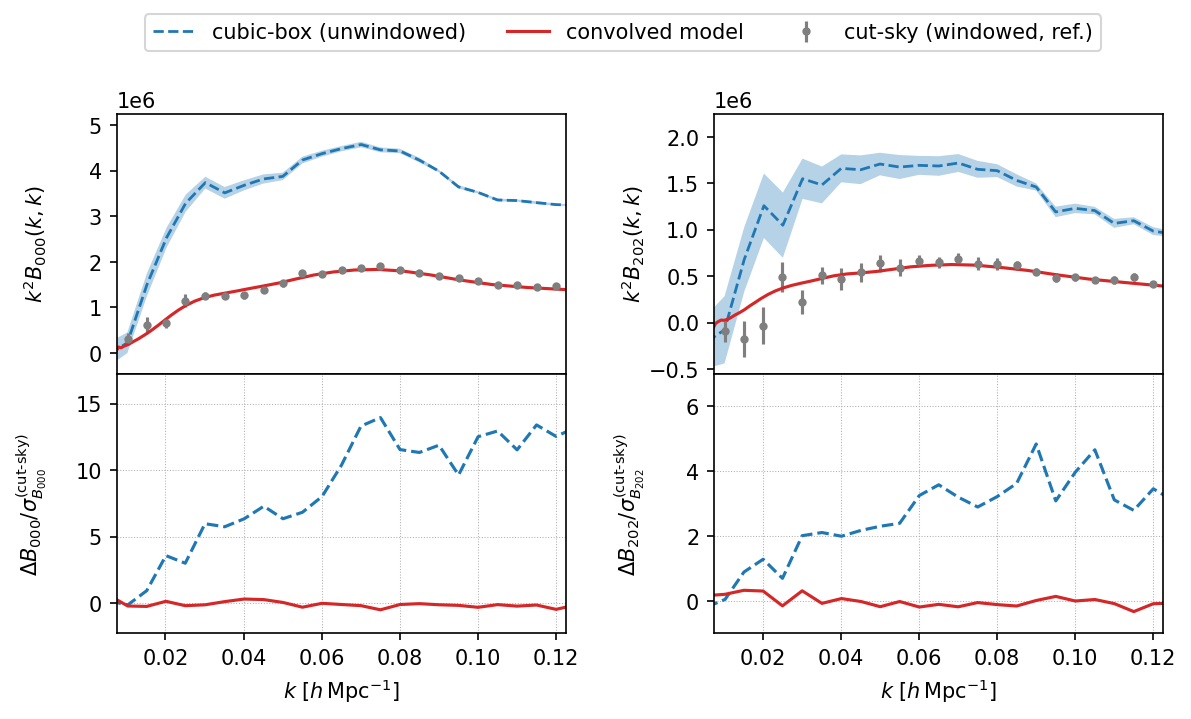

In [8]:
LW = 1.33
ALPHA = 0.33

COORD_POWIDX = 2
KMIN, KMAX = 0.0050, 0.1225
BINIDX = list(range(1, 24, 2))

fig, ax = plt.subplots(
    2, len(winconv_formula.multipoles),
    figsize=(4.5*len(winconv_formula.multipoles), 4.5),
    sharex=True,
    dpi=150,
)
ax = ax if isinstance(ax, np.ndarray) else [ax]

for ax_, multipole in zip(ax.T, winconv_formula.multipoles):

    line_box = ax_[0].plot(
        k_box, k_box**COORD_POWIDX * bk_box[multipole],
        c='C0', ls='--', lw=LW,
        label="cubic-box (unwindowed)"
    )
    bounds_box = ax_[0].fill_between(
        k_box,
        k_box**COORD_POWIDX * (bk_box[multipole] - dbk_box[multipole]),
        k_box**COORD_POWIDX * (bk_box[multipole] + dbk_box[multipole]),
        fc=line_box[-1].get_color(), ec='none', alpha=ALPHA
    )

    line_sky = ax_[0].errorbar(
        k_sky,
        k_sky**COORD_POWIDX * bk_sky[multipole],
        yerr=k_sky**COORD_POWIDX * dbk_sky[multipole],
        fmt='o', ms=3., c='C7',
        label="cut-sky (windowed, ref.)",
    )

    line_conv = ax_[0].plot(
        k_conv,
        k_conv**COORD_POWIDX * np.diag(bkk_conv[multipole]).real,
        c='C3', ls='-',
        label='convolved model'
    )

    bk_box_pole = InterpolatedUnivariateSpline(
        k_box, bk_box[multipole].real
    )(k_sky)
    bk_conv_pole = InterpolatedUnivariateSpline(
        k_conv, np.diag(bkk_conv[multipole]).real
    )(k_sky)

    ax_[1].plot(
        k_sky,
        (bk_box_pole - bk_sky[multipole]) / dbk_sky[multipole] / np.sqrt(N_sky),
        c='C0', ls='--'
    )
    ax_[1].plot(
        k_sky,
        (bk_conv_pole - bk_sky[multipole]) / dbk_sky[multipole] / np.sqrt(N_sky),
        c='C3', ls='-'
    )

    ax_[1].grid(True, which='both', ls=':', lw=0.5)

    ax_[0].set_xlim(KMIN, KMAX)
    ax_[0].set_xlim(0.0075, KMAX)
    if multipole.abstr == '000':
        ax_[0].set_ylim(-0.45e6, 5.25e6)
        ax_[1].set_ylim(-2.25, 17.25)
    if multipole.abstr == '202':
        ax_[0].set_ylim(-0.55e6, 2.25e6)
        ax_[1].set_ylim(-1., 7.)

    ax_[0].ticklabel_format(useOffset=False)
    ax_[1].set_xlabel(r"$k$ [$h\,\mathrm{Mpc}^{-1}$]")
    ax_[0].set_ylabel(fr"$k^{{{COORD_POWIDX}}} B_{{{multipole.abstr}}}(k, k)$")
    ax_[1].set_ylabel(fr"$\Delta B_{{{multipole.abstr}}} / \sigma_{{B_{{{multipole.abstr}}}}}^{{\text{{(cut-sky)}}}}$")

    ax_[0].yaxis.set_label_coords(-0.15, 0.5)
    ax_[1].yaxis.set_label_coords(-0.15, 0.5)

    if ax_[0] is ax[0, 0]:
        handles, labels = ax_[0].get_legend_handles_labels()

ordering = [0, 1, 2]
handles = [handles[idx] for idx in ordering]
labels = [labels[idx] for idx in ordering]

fig.legend(
    handles, labels,
    ncol=3, bbox_to_anchor=(0.5, 1.0), loc='center'
)

fig.subplots_adjust(hspace=0., wspace=0.33)